In [1]:
#https://yjucho1.github.io/attention/attention/

In [2]:
%matplotlib inline

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import matplotlib.pyplot as plt

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [4]:
corpus_name = "cornell movie-dialogs corpus"
corpus = os.path.join("data", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "movie_lines.txt"))

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'


In [5]:
# Splits each line of the file into a dictionary of fields
def loadLines(fileName, fields):
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines


# Groups fields of lines from `loadLines` into conversations based on *movie_conversations.txt*
def loadConversations(fileName, lines, fields):
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            # Convert string to list (convObj["utteranceIDs"] == "['L598485', 'L598486', ...]")
            utterance_id_pattern = re.compile('L[0-9]+')
            lineIds = utterance_id_pattern.findall(convObj["utteranceIDs"])
            # Reassemble lines
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

In [6]:
#위에서 라인을 읽고, 대화를 읽고, 문장쌍으로 구성한 뒤 새 파일을 만듦

# Define path to new file
datafile = os.path.join(corpus, "formatted_movie_lines.txt") 

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict, conversations list, and field ids
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]

# Load lines and process conversations
print("\nProcessing corpus...")
lines = loadLines(os.path.join(corpus, "movie_lines.txt"), MOVIE_LINES_FIELDS)
print("\nLoading conversations...")
conversations = loadConversations(os.path.join(corpus, "movie_conversations.txt"),
                                  lines, MOVIE_CONVERSATIONS_FIELDS)

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines
print("\nSample lines from file:")
printLines(datafile)


Processing corpus...

Loading conversations...

Writing newly formatted file...

Sample lines from file:
b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\r\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\r\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\r\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\r\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\r\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\r\n"
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister. 

In [7]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [8]:
#전처리 과정
#ASCII로 변환, 문자가 아닌 텍스트 삭제(모두 다 삭제는 아님), 문장 길이 threshold 적용

MAX_LENGTH = 10  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64271 sentence pairs
Counting words...
Counted words: 18008

pairs:
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']


In [9]:
#자주 등장하지 않은 단어 생략

MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs #word2index 중 사용하는 아이 프린트해줌. 위의 keep_pairs참조


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7823 / 18005 = 0.4345
Trimmed from 64271 pairs to 53165, 0.8272 of total


In [10]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[ 158, 4092,  167,   18,   67],
        [ 709, 4070,  122,   50,  720],
        [  66,  247,    7,    6,    4],
        [  98,  117,  153,    2,    2],
        [ 414,  282,    2,    0,    0],
        [1100,    4,    0,    0,    0],
        [ 158,    2,    0,    0,    0],
        [ 709,    0,    0,    0,    0],
        [  66,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([10,  7,  5,  4,  4])
target_variable: tensor([[  77,   42,    7,   18,   47],
        [  37,   25,   24,  980,   76],
        [ 534,   39,   45,    4,    4],
        [  53,  296,   66,    2,    2],
        [6885,  253,    2,    0,    0],
        [   6, 4093,    0,    0,    0],
        [   2,  153,    0,    0,    0],
        [   0, 4094,    0,    0,    0],
        [   0,    4,    0,    0,    0],
        [   0,    2,    0,    0,    0]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [12]:
# Luong attention layer
# Luong attention : 모든 encoder의 hidden state를 고려함
# Bahdanau attention : 현재 time step에서의 encoder hidden state 고려함
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [13]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [14]:
def maskNLLLoss(inp, target, mask):
    #print(mask)
    #nTotal = mask.sum()
    #저게 안 먹어서
    nTotal = torch.sum((mask == True).int())
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask.byte()).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [15]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [16]:
lossPlot = []

def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0: #아래에 print_every == 1
            print_loss_avg = print_loss / print_every
            lossPlot.append(print_loss_avg)
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

In [17]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [18]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [19]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [20]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000 #4000이었는데 늘려봄 #늘리면 이상함;
print_every = 1
save_every = 500

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()
    
# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1; Percent complete: 0.0%; Average loss: 8.9615
Iteration: 2; Percent complete: 0.1%; Average loss: 8.8464
Iteration: 3; Percent complete: 0.1%; Average loss: 8.6533
Iteration: 4; Percent complete: 0.1%; Average loss: 8.3507
Iteration: 5; Percent complete: 0.1%; Average loss: 7.9373
Iteration: 6; Percent complete: 0.1%; Average loss: 7.3181
Iteration: 7; Percent complete: 0.2%; Average loss: 6.7678
Iteration: 8; Percent complete: 0.2%; Average loss: 6.5752
Iteration: 9; Percent complete: 0.2%; Average loss: 6.6290
Iteration: 10; Percent complete: 0.2%; Average loss: 6.5198
Iteration: 11; Percent complete: 0.3%; Average loss: 6.0594
Iteration: 12; Percent complete: 0.3%; Average loss: 5.8845
Iteration: 13; Percent complete: 0.3%; Average loss: 5.7823
Iteration: 14; Percent complete: 0.4%; Average loss: 5.4828
Iteration: 15; Percent complete: 0.4%; Average loss: 5.6441
Iteration: 16; Percent complete: 0.4%

Iteration: 135; Percent complete: 3.4%; Average loss: 4.2313
Iteration: 136; Percent complete: 3.4%; Average loss: 4.3735
Iteration: 137; Percent complete: 3.4%; Average loss: 4.1154
Iteration: 138; Percent complete: 3.5%; Average loss: 4.4395
Iteration: 139; Percent complete: 3.5%; Average loss: 4.4820
Iteration: 140; Percent complete: 3.5%; Average loss: 4.3283
Iteration: 141; Percent complete: 3.5%; Average loss: 4.1701
Iteration: 142; Percent complete: 3.5%; Average loss: 4.3240
Iteration: 143; Percent complete: 3.6%; Average loss: 4.3016
Iteration: 144; Percent complete: 3.6%; Average loss: 4.0582
Iteration: 145; Percent complete: 3.6%; Average loss: 4.4940
Iteration: 146; Percent complete: 3.6%; Average loss: 4.4723
Iteration: 147; Percent complete: 3.7%; Average loss: 4.2736
Iteration: 148; Percent complete: 3.7%; Average loss: 4.3203
Iteration: 149; Percent complete: 3.7%; Average loss: 4.3064
Iteration: 150; Percent complete: 3.8%; Average loss: 4.3574
Iteration: 151; Percent 

Iteration: 269; Percent complete: 6.7%; Average loss: 3.9312
Iteration: 270; Percent complete: 6.8%; Average loss: 4.1155
Iteration: 271; Percent complete: 6.8%; Average loss: 4.1052
Iteration: 272; Percent complete: 6.8%; Average loss: 3.7684
Iteration: 273; Percent complete: 6.8%; Average loss: 3.9443
Iteration: 274; Percent complete: 6.9%; Average loss: 3.9797
Iteration: 275; Percent complete: 6.9%; Average loss: 4.1391
Iteration: 276; Percent complete: 6.9%; Average loss: 3.9774
Iteration: 277; Percent complete: 6.9%; Average loss: 4.1081
Iteration: 278; Percent complete: 7.0%; Average loss: 3.9543
Iteration: 279; Percent complete: 7.0%; Average loss: 3.9889
Iteration: 280; Percent complete: 7.0%; Average loss: 3.7989
Iteration: 281; Percent complete: 7.0%; Average loss: 4.0230
Iteration: 282; Percent complete: 7.0%; Average loss: 3.9905
Iteration: 283; Percent complete: 7.1%; Average loss: 3.8088
Iteration: 284; Percent complete: 7.1%; Average loss: 4.0040
Iteration: 285; Percent 

Iteration: 403; Percent complete: 10.1%; Average loss: 3.7685
Iteration: 404; Percent complete: 10.1%; Average loss: 3.7767
Iteration: 405; Percent complete: 10.1%; Average loss: 3.6814
Iteration: 406; Percent complete: 10.2%; Average loss: 3.8164
Iteration: 407; Percent complete: 10.2%; Average loss: 3.5771
Iteration: 408; Percent complete: 10.2%; Average loss: 3.6526
Iteration: 409; Percent complete: 10.2%; Average loss: 3.7868
Iteration: 410; Percent complete: 10.2%; Average loss: 3.9803
Iteration: 411; Percent complete: 10.3%; Average loss: 3.6637
Iteration: 412; Percent complete: 10.3%; Average loss: 3.7628
Iteration: 413; Percent complete: 10.3%; Average loss: 3.8685
Iteration: 414; Percent complete: 10.3%; Average loss: 3.9512
Iteration: 415; Percent complete: 10.4%; Average loss: 3.8911
Iteration: 416; Percent complete: 10.4%; Average loss: 3.4492
Iteration: 417; Percent complete: 10.4%; Average loss: 3.9580
Iteration: 418; Percent complete: 10.4%; Average loss: 3.8074
Iteratio

Iteration: 535; Percent complete: 13.4%; Average loss: 3.5945
Iteration: 536; Percent complete: 13.4%; Average loss: 3.7430
Iteration: 537; Percent complete: 13.4%; Average loss: 3.4717
Iteration: 538; Percent complete: 13.5%; Average loss: 3.7013
Iteration: 539; Percent complete: 13.5%; Average loss: 3.6573
Iteration: 540; Percent complete: 13.5%; Average loss: 3.5727
Iteration: 541; Percent complete: 13.5%; Average loss: 3.7818
Iteration: 542; Percent complete: 13.6%; Average loss: 3.7582
Iteration: 543; Percent complete: 13.6%; Average loss: 3.3564
Iteration: 544; Percent complete: 13.6%; Average loss: 3.5303
Iteration: 545; Percent complete: 13.6%; Average loss: 3.8205
Iteration: 546; Percent complete: 13.7%; Average loss: 3.8159
Iteration: 547; Percent complete: 13.7%; Average loss: 3.8500
Iteration: 548; Percent complete: 13.7%; Average loss: 3.5045
Iteration: 549; Percent complete: 13.7%; Average loss: 3.8019
Iteration: 550; Percent complete: 13.8%; Average loss: 4.0080
Iteratio

Iteration: 667; Percent complete: 16.7%; Average loss: 3.7358
Iteration: 668; Percent complete: 16.7%; Average loss: 3.5314
Iteration: 669; Percent complete: 16.7%; Average loss: 3.4136
Iteration: 670; Percent complete: 16.8%; Average loss: 3.6626
Iteration: 671; Percent complete: 16.8%; Average loss: 3.6918
Iteration: 672; Percent complete: 16.8%; Average loss: 3.5302
Iteration: 673; Percent complete: 16.8%; Average loss: 3.7030
Iteration: 674; Percent complete: 16.9%; Average loss: 3.6420
Iteration: 675; Percent complete: 16.9%; Average loss: 3.6407
Iteration: 676; Percent complete: 16.9%; Average loss: 3.7344
Iteration: 677; Percent complete: 16.9%; Average loss: 3.6708
Iteration: 678; Percent complete: 17.0%; Average loss: 3.6123
Iteration: 679; Percent complete: 17.0%; Average loss: 3.6842
Iteration: 680; Percent complete: 17.0%; Average loss: 3.7105
Iteration: 681; Percent complete: 17.0%; Average loss: 3.5361
Iteration: 682; Percent complete: 17.1%; Average loss: 3.4462
Iteratio

Iteration: 799; Percent complete: 20.0%; Average loss: 3.3581
Iteration: 800; Percent complete: 20.0%; Average loss: 3.4172
Iteration: 801; Percent complete: 20.0%; Average loss: 3.5288
Iteration: 802; Percent complete: 20.1%; Average loss: 3.6317
Iteration: 803; Percent complete: 20.1%; Average loss: 3.1416
Iteration: 804; Percent complete: 20.1%; Average loss: 3.8690
Iteration: 805; Percent complete: 20.1%; Average loss: 3.6353
Iteration: 806; Percent complete: 20.2%; Average loss: 3.4622
Iteration: 807; Percent complete: 20.2%; Average loss: 3.5534
Iteration: 808; Percent complete: 20.2%; Average loss: 3.5817
Iteration: 809; Percent complete: 20.2%; Average loss: 3.4316
Iteration: 810; Percent complete: 20.2%; Average loss: 3.6074
Iteration: 811; Percent complete: 20.3%; Average loss: 3.3360
Iteration: 812; Percent complete: 20.3%; Average loss: 3.6438
Iteration: 813; Percent complete: 20.3%; Average loss: 3.4825
Iteration: 814; Percent complete: 20.3%; Average loss: 3.4743
Iteratio

Iteration: 931; Percent complete: 23.3%; Average loss: 3.4314
Iteration: 932; Percent complete: 23.3%; Average loss: 3.5090
Iteration: 933; Percent complete: 23.3%; Average loss: 3.6916
Iteration: 934; Percent complete: 23.4%; Average loss: 3.3848
Iteration: 935; Percent complete: 23.4%; Average loss: 3.7108
Iteration: 936; Percent complete: 23.4%; Average loss: 3.7034
Iteration: 937; Percent complete: 23.4%; Average loss: 3.4311
Iteration: 938; Percent complete: 23.4%; Average loss: 3.4270
Iteration: 939; Percent complete: 23.5%; Average loss: 3.2887
Iteration: 940; Percent complete: 23.5%; Average loss: 3.5828
Iteration: 941; Percent complete: 23.5%; Average loss: 3.6203
Iteration: 942; Percent complete: 23.5%; Average loss: 3.3845
Iteration: 943; Percent complete: 23.6%; Average loss: 3.3706
Iteration: 944; Percent complete: 23.6%; Average loss: 3.5871
Iteration: 945; Percent complete: 23.6%; Average loss: 3.6152
Iteration: 946; Percent complete: 23.6%; Average loss: 3.4961
Iteratio

Iteration: 1062; Percent complete: 26.6%; Average loss: 3.3249
Iteration: 1063; Percent complete: 26.6%; Average loss: 3.4836
Iteration: 1064; Percent complete: 26.6%; Average loss: 3.3232
Iteration: 1065; Percent complete: 26.6%; Average loss: 3.2775
Iteration: 1066; Percent complete: 26.7%; Average loss: 3.4444
Iteration: 1067; Percent complete: 26.7%; Average loss: 3.6355
Iteration: 1068; Percent complete: 26.7%; Average loss: 3.6480
Iteration: 1069; Percent complete: 26.7%; Average loss: 3.6897
Iteration: 1070; Percent complete: 26.8%; Average loss: 3.5311
Iteration: 1071; Percent complete: 26.8%; Average loss: 3.0854
Iteration: 1072; Percent complete: 26.8%; Average loss: 3.5053
Iteration: 1073; Percent complete: 26.8%; Average loss: 3.2653
Iteration: 1074; Percent complete: 26.9%; Average loss: 3.2894
Iteration: 1075; Percent complete: 26.9%; Average loss: 3.5631
Iteration: 1076; Percent complete: 26.9%; Average loss: 3.8305
Iteration: 1077; Percent complete: 26.9%; Average loss:

Iteration: 1192; Percent complete: 29.8%; Average loss: 3.5194
Iteration: 1193; Percent complete: 29.8%; Average loss: 3.1949
Iteration: 1194; Percent complete: 29.8%; Average loss: 3.1455
Iteration: 1195; Percent complete: 29.9%; Average loss: 3.5250
Iteration: 1196; Percent complete: 29.9%; Average loss: 3.3830
Iteration: 1197; Percent complete: 29.9%; Average loss: 3.4053
Iteration: 1198; Percent complete: 29.9%; Average loss: 3.4628
Iteration: 1199; Percent complete: 30.0%; Average loss: 3.4135
Iteration: 1200; Percent complete: 30.0%; Average loss: 3.2282
Iteration: 1201; Percent complete: 30.0%; Average loss: 3.4683
Iteration: 1202; Percent complete: 30.0%; Average loss: 3.2759
Iteration: 1203; Percent complete: 30.1%; Average loss: 3.4796
Iteration: 1204; Percent complete: 30.1%; Average loss: 3.3084
Iteration: 1205; Percent complete: 30.1%; Average loss: 3.2047
Iteration: 1206; Percent complete: 30.1%; Average loss: 3.2100
Iteration: 1207; Percent complete: 30.2%; Average loss:

Iteration: 1322; Percent complete: 33.1%; Average loss: 3.5669
Iteration: 1323; Percent complete: 33.1%; Average loss: 3.4692
Iteration: 1324; Percent complete: 33.1%; Average loss: 3.2494
Iteration: 1325; Percent complete: 33.1%; Average loss: 3.3453
Iteration: 1326; Percent complete: 33.1%; Average loss: 3.4537
Iteration: 1327; Percent complete: 33.2%; Average loss: 3.4355
Iteration: 1328; Percent complete: 33.2%; Average loss: 3.2245
Iteration: 1329; Percent complete: 33.2%; Average loss: 3.1875
Iteration: 1330; Percent complete: 33.2%; Average loss: 3.3569
Iteration: 1331; Percent complete: 33.3%; Average loss: 3.0048
Iteration: 1332; Percent complete: 33.3%; Average loss: 3.4009
Iteration: 1333; Percent complete: 33.3%; Average loss: 3.5043
Iteration: 1334; Percent complete: 33.4%; Average loss: 3.3900
Iteration: 1335; Percent complete: 33.4%; Average loss: 3.3880
Iteration: 1336; Percent complete: 33.4%; Average loss: 3.3211
Iteration: 1337; Percent complete: 33.4%; Average loss:

Iteration: 1452; Percent complete: 36.3%; Average loss: 3.5434
Iteration: 1453; Percent complete: 36.3%; Average loss: 3.1934
Iteration: 1454; Percent complete: 36.4%; Average loss: 3.3802
Iteration: 1455; Percent complete: 36.4%; Average loss: 3.3002
Iteration: 1456; Percent complete: 36.4%; Average loss: 3.4401
Iteration: 1457; Percent complete: 36.4%; Average loss: 3.6055
Iteration: 1458; Percent complete: 36.4%; Average loss: 3.3337
Iteration: 1459; Percent complete: 36.5%; Average loss: 3.0282
Iteration: 1460; Percent complete: 36.5%; Average loss: 3.2330
Iteration: 1461; Percent complete: 36.5%; Average loss: 3.4307
Iteration: 1462; Percent complete: 36.5%; Average loss: 3.1711
Iteration: 1463; Percent complete: 36.6%; Average loss: 3.4013
Iteration: 1464; Percent complete: 36.6%; Average loss: 3.2767
Iteration: 1465; Percent complete: 36.6%; Average loss: 3.4060
Iteration: 1466; Percent complete: 36.6%; Average loss: 3.3412
Iteration: 1467; Percent complete: 36.7%; Average loss:

Iteration: 1582; Percent complete: 39.6%; Average loss: 3.3541
Iteration: 1583; Percent complete: 39.6%; Average loss: 3.2653
Iteration: 1584; Percent complete: 39.6%; Average loss: 3.3942
Iteration: 1585; Percent complete: 39.6%; Average loss: 3.2756
Iteration: 1586; Percent complete: 39.6%; Average loss: 3.1532
Iteration: 1587; Percent complete: 39.7%; Average loss: 3.1729
Iteration: 1588; Percent complete: 39.7%; Average loss: 3.4387
Iteration: 1589; Percent complete: 39.7%; Average loss: 3.1642
Iteration: 1590; Percent complete: 39.8%; Average loss: 3.3650
Iteration: 1591; Percent complete: 39.8%; Average loss: 3.3245
Iteration: 1592; Percent complete: 39.8%; Average loss: 3.4858
Iteration: 1593; Percent complete: 39.8%; Average loss: 3.5810
Iteration: 1594; Percent complete: 39.9%; Average loss: 3.5364
Iteration: 1595; Percent complete: 39.9%; Average loss: 3.3684
Iteration: 1596; Percent complete: 39.9%; Average loss: 3.1294
Iteration: 1597; Percent complete: 39.9%; Average loss:

Iteration: 1712; Percent complete: 42.8%; Average loss: 3.2289
Iteration: 1713; Percent complete: 42.8%; Average loss: 3.5669
Iteration: 1714; Percent complete: 42.9%; Average loss: 3.4634
Iteration: 1715; Percent complete: 42.9%; Average loss: 3.3421
Iteration: 1716; Percent complete: 42.9%; Average loss: 3.0445
Iteration: 1717; Percent complete: 42.9%; Average loss: 3.4070
Iteration: 1718; Percent complete: 43.0%; Average loss: 3.2906
Iteration: 1719; Percent complete: 43.0%; Average loss: 3.2383
Iteration: 1720; Percent complete: 43.0%; Average loss: 3.2789
Iteration: 1721; Percent complete: 43.0%; Average loss: 3.3462
Iteration: 1722; Percent complete: 43.0%; Average loss: 3.4358
Iteration: 1723; Percent complete: 43.1%; Average loss: 3.2722
Iteration: 1724; Percent complete: 43.1%; Average loss: 3.5683
Iteration: 1725; Percent complete: 43.1%; Average loss: 3.0893
Iteration: 1726; Percent complete: 43.1%; Average loss: 3.1127
Iteration: 1727; Percent complete: 43.2%; Average loss:

Iteration: 1842; Percent complete: 46.1%; Average loss: 3.1403
Iteration: 1843; Percent complete: 46.1%; Average loss: 3.0319
Iteration: 1844; Percent complete: 46.1%; Average loss: 3.1640
Iteration: 1845; Percent complete: 46.1%; Average loss: 3.1689
Iteration: 1846; Percent complete: 46.2%; Average loss: 3.2732
Iteration: 1847; Percent complete: 46.2%; Average loss: 3.2939
Iteration: 1848; Percent complete: 46.2%; Average loss: 3.3794
Iteration: 1849; Percent complete: 46.2%; Average loss: 3.3393
Iteration: 1850; Percent complete: 46.2%; Average loss: 3.0406
Iteration: 1851; Percent complete: 46.3%; Average loss: 3.1851
Iteration: 1852; Percent complete: 46.3%; Average loss: 3.0555
Iteration: 1853; Percent complete: 46.3%; Average loss: 3.2064
Iteration: 1854; Percent complete: 46.4%; Average loss: 3.1025
Iteration: 1855; Percent complete: 46.4%; Average loss: 3.2663
Iteration: 1856; Percent complete: 46.4%; Average loss: 3.3217
Iteration: 1857; Percent complete: 46.4%; Average loss:

Iteration: 1972; Percent complete: 49.3%; Average loss: 3.2208
Iteration: 1973; Percent complete: 49.3%; Average loss: 3.3926
Iteration: 1974; Percent complete: 49.4%; Average loss: 3.3416
Iteration: 1975; Percent complete: 49.4%; Average loss: 3.1481
Iteration: 1976; Percent complete: 49.4%; Average loss: 3.2992
Iteration: 1977; Percent complete: 49.4%; Average loss: 3.1339
Iteration: 1978; Percent complete: 49.5%; Average loss: 3.2435
Iteration: 1979; Percent complete: 49.5%; Average loss: 3.0410
Iteration: 1980; Percent complete: 49.5%; Average loss: 3.2089
Iteration: 1981; Percent complete: 49.5%; Average loss: 3.1736
Iteration: 1982; Percent complete: 49.5%; Average loss: 3.4161
Iteration: 1983; Percent complete: 49.6%; Average loss: 3.2419
Iteration: 1984; Percent complete: 49.6%; Average loss: 3.2135
Iteration: 1985; Percent complete: 49.6%; Average loss: 3.0535
Iteration: 1986; Percent complete: 49.6%; Average loss: 3.1421
Iteration: 1987; Percent complete: 49.7%; Average loss:

Iteration: 2102; Percent complete: 52.5%; Average loss: 3.1329
Iteration: 2103; Percent complete: 52.6%; Average loss: 2.8529
Iteration: 2104; Percent complete: 52.6%; Average loss: 2.9786
Iteration: 2105; Percent complete: 52.6%; Average loss: 2.8596
Iteration: 2106; Percent complete: 52.6%; Average loss: 3.2624
Iteration: 2107; Percent complete: 52.7%; Average loss: 3.0461
Iteration: 2108; Percent complete: 52.7%; Average loss: 3.1492
Iteration: 2109; Percent complete: 52.7%; Average loss: 2.9796
Iteration: 2110; Percent complete: 52.8%; Average loss: 3.0314
Iteration: 2111; Percent complete: 52.8%; Average loss: 3.0645
Iteration: 2112; Percent complete: 52.8%; Average loss: 2.9511
Iteration: 2113; Percent complete: 52.8%; Average loss: 3.0409
Iteration: 2114; Percent complete: 52.8%; Average loss: 3.1921
Iteration: 2115; Percent complete: 52.9%; Average loss: 3.2495
Iteration: 2116; Percent complete: 52.9%; Average loss: 3.1551
Iteration: 2117; Percent complete: 52.9%; Average loss:

Iteration: 2232; Percent complete: 55.8%; Average loss: 3.0664
Iteration: 2233; Percent complete: 55.8%; Average loss: 3.1426
Iteration: 2234; Percent complete: 55.9%; Average loss: 3.3108
Iteration: 2235; Percent complete: 55.9%; Average loss: 3.0823
Iteration: 2236; Percent complete: 55.9%; Average loss: 2.9322
Iteration: 2237; Percent complete: 55.9%; Average loss: 3.0608
Iteration: 2238; Percent complete: 56.0%; Average loss: 2.9513
Iteration: 2239; Percent complete: 56.0%; Average loss: 3.0626
Iteration: 2240; Percent complete: 56.0%; Average loss: 2.9285
Iteration: 2241; Percent complete: 56.0%; Average loss: 3.3325
Iteration: 2242; Percent complete: 56.0%; Average loss: 3.0907
Iteration: 2243; Percent complete: 56.1%; Average loss: 3.0408
Iteration: 2244; Percent complete: 56.1%; Average loss: 2.9959
Iteration: 2245; Percent complete: 56.1%; Average loss: 3.1619
Iteration: 2246; Percent complete: 56.1%; Average loss: 2.9373
Iteration: 2247; Percent complete: 56.2%; Average loss:

Iteration: 2362; Percent complete: 59.1%; Average loss: 2.8536
Iteration: 2363; Percent complete: 59.1%; Average loss: 3.2211
Iteration: 2364; Percent complete: 59.1%; Average loss: 3.2430
Iteration: 2365; Percent complete: 59.1%; Average loss: 3.1715
Iteration: 2366; Percent complete: 59.2%; Average loss: 3.2738
Iteration: 2367; Percent complete: 59.2%; Average loss: 2.8688
Iteration: 2368; Percent complete: 59.2%; Average loss: 3.0971
Iteration: 2369; Percent complete: 59.2%; Average loss: 3.0794
Iteration: 2370; Percent complete: 59.2%; Average loss: 3.2402
Iteration: 2371; Percent complete: 59.3%; Average loss: 2.7965
Iteration: 2372; Percent complete: 59.3%; Average loss: 3.0349
Iteration: 2373; Percent complete: 59.3%; Average loss: 3.5192
Iteration: 2374; Percent complete: 59.4%; Average loss: 3.0412
Iteration: 2375; Percent complete: 59.4%; Average loss: 2.9255
Iteration: 2376; Percent complete: 59.4%; Average loss: 3.1687
Iteration: 2377; Percent complete: 59.4%; Average loss:

Iteration: 2492; Percent complete: 62.3%; Average loss: 2.8045
Iteration: 2493; Percent complete: 62.3%; Average loss: 2.9144
Iteration: 2494; Percent complete: 62.4%; Average loss: 3.1945
Iteration: 2495; Percent complete: 62.4%; Average loss: 3.2603
Iteration: 2496; Percent complete: 62.4%; Average loss: 2.9591
Iteration: 2497; Percent complete: 62.4%; Average loss: 2.9904
Iteration: 2498; Percent complete: 62.5%; Average loss: 2.8760
Iteration: 2499; Percent complete: 62.5%; Average loss: 3.2033
Iteration: 2500; Percent complete: 62.5%; Average loss: 3.1610
Iteration: 2501; Percent complete: 62.5%; Average loss: 2.8718
Iteration: 2502; Percent complete: 62.5%; Average loss: 3.1232
Iteration: 2503; Percent complete: 62.6%; Average loss: 3.0088
Iteration: 2504; Percent complete: 62.6%; Average loss: 2.7951
Iteration: 2505; Percent complete: 62.6%; Average loss: 3.0966
Iteration: 2506; Percent complete: 62.6%; Average loss: 2.9298
Iteration: 2507; Percent complete: 62.7%; Average loss:

Iteration: 2622; Percent complete: 65.5%; Average loss: 2.8680
Iteration: 2623; Percent complete: 65.6%; Average loss: 2.9760
Iteration: 2624; Percent complete: 65.6%; Average loss: 2.9063
Iteration: 2625; Percent complete: 65.6%; Average loss: 3.1793
Iteration: 2626; Percent complete: 65.6%; Average loss: 2.8755
Iteration: 2627; Percent complete: 65.7%; Average loss: 2.6456
Iteration: 2628; Percent complete: 65.7%; Average loss: 3.0705
Iteration: 2629; Percent complete: 65.7%; Average loss: 2.7796
Iteration: 2630; Percent complete: 65.8%; Average loss: 3.1905
Iteration: 2631; Percent complete: 65.8%; Average loss: 2.8322
Iteration: 2632; Percent complete: 65.8%; Average loss: 2.9856
Iteration: 2633; Percent complete: 65.8%; Average loss: 2.9829
Iteration: 2634; Percent complete: 65.8%; Average loss: 3.0104
Iteration: 2635; Percent complete: 65.9%; Average loss: 2.8575
Iteration: 2636; Percent complete: 65.9%; Average loss: 2.9268
Iteration: 2637; Percent complete: 65.9%; Average loss:

Iteration: 2752; Percent complete: 68.8%; Average loss: 2.9716
Iteration: 2753; Percent complete: 68.8%; Average loss: 3.0488
Iteration: 2754; Percent complete: 68.8%; Average loss: 2.6406
Iteration: 2755; Percent complete: 68.9%; Average loss: 2.7676
Iteration: 2756; Percent complete: 68.9%; Average loss: 2.9233
Iteration: 2757; Percent complete: 68.9%; Average loss: 2.7136
Iteration: 2758; Percent complete: 69.0%; Average loss: 2.9680
Iteration: 2759; Percent complete: 69.0%; Average loss: 2.7744
Iteration: 2760; Percent complete: 69.0%; Average loss: 3.0492
Iteration: 2761; Percent complete: 69.0%; Average loss: 2.8496
Iteration: 2762; Percent complete: 69.0%; Average loss: 2.8909
Iteration: 2763; Percent complete: 69.1%; Average loss: 3.0882
Iteration: 2764; Percent complete: 69.1%; Average loss: 3.0692
Iteration: 2765; Percent complete: 69.1%; Average loss: 3.1527
Iteration: 2766; Percent complete: 69.2%; Average loss: 3.1839
Iteration: 2767; Percent complete: 69.2%; Average loss:

Iteration: 2882; Percent complete: 72.0%; Average loss: 3.0209
Iteration: 2883; Percent complete: 72.1%; Average loss: 2.8616
Iteration: 2884; Percent complete: 72.1%; Average loss: 2.7918
Iteration: 2885; Percent complete: 72.1%; Average loss: 2.9578
Iteration: 2886; Percent complete: 72.2%; Average loss: 2.9175
Iteration: 2887; Percent complete: 72.2%; Average loss: 2.8237
Iteration: 2888; Percent complete: 72.2%; Average loss: 2.9508
Iteration: 2889; Percent complete: 72.2%; Average loss: 3.1599
Iteration: 2890; Percent complete: 72.2%; Average loss: 2.6971
Iteration: 2891; Percent complete: 72.3%; Average loss: 3.2529
Iteration: 2892; Percent complete: 72.3%; Average loss: 2.8898
Iteration: 2893; Percent complete: 72.3%; Average loss: 2.6810
Iteration: 2894; Percent complete: 72.4%; Average loss: 2.9017
Iteration: 2895; Percent complete: 72.4%; Average loss: 2.8280
Iteration: 2896; Percent complete: 72.4%; Average loss: 3.1160
Iteration: 2897; Percent complete: 72.4%; Average loss:

Iteration: 3012; Percent complete: 75.3%; Average loss: 2.8457
Iteration: 3013; Percent complete: 75.3%; Average loss: 2.9032
Iteration: 3014; Percent complete: 75.3%; Average loss: 2.9052
Iteration: 3015; Percent complete: 75.4%; Average loss: 2.8903
Iteration: 3016; Percent complete: 75.4%; Average loss: 2.7592
Iteration: 3017; Percent complete: 75.4%; Average loss: 2.7294
Iteration: 3018; Percent complete: 75.4%; Average loss: 2.9884
Iteration: 3019; Percent complete: 75.5%; Average loss: 2.8527
Iteration: 3020; Percent complete: 75.5%; Average loss: 2.8485
Iteration: 3021; Percent complete: 75.5%; Average loss: 2.9142
Iteration: 3022; Percent complete: 75.5%; Average loss: 3.1248
Iteration: 3023; Percent complete: 75.6%; Average loss: 2.9934
Iteration: 3024; Percent complete: 75.6%; Average loss: 2.7163
Iteration: 3025; Percent complete: 75.6%; Average loss: 3.0601
Iteration: 3026; Percent complete: 75.6%; Average loss: 2.6549
Iteration: 3027; Percent complete: 75.7%; Average loss:

Iteration: 3142; Percent complete: 78.5%; Average loss: 2.8973
Iteration: 3143; Percent complete: 78.6%; Average loss: 2.8444
Iteration: 3144; Percent complete: 78.6%; Average loss: 2.7462
Iteration: 3145; Percent complete: 78.6%; Average loss: 2.7658
Iteration: 3146; Percent complete: 78.6%; Average loss: 2.7532
Iteration: 3147; Percent complete: 78.7%; Average loss: 2.8728
Iteration: 3148; Percent complete: 78.7%; Average loss: 2.7643
Iteration: 3149; Percent complete: 78.7%; Average loss: 3.1454
Iteration: 3150; Percent complete: 78.8%; Average loss: 2.6754
Iteration: 3151; Percent complete: 78.8%; Average loss: 2.9305
Iteration: 3152; Percent complete: 78.8%; Average loss: 2.8252
Iteration: 3153; Percent complete: 78.8%; Average loss: 2.5752
Iteration: 3154; Percent complete: 78.8%; Average loss: 2.9486
Iteration: 3155; Percent complete: 78.9%; Average loss: 2.9522
Iteration: 3156; Percent complete: 78.9%; Average loss: 2.6987
Iteration: 3157; Percent complete: 78.9%; Average loss:

Iteration: 3272; Percent complete: 81.8%; Average loss: 2.8768
Iteration: 3273; Percent complete: 81.8%; Average loss: 2.8520
Iteration: 3274; Percent complete: 81.8%; Average loss: 2.7575
Iteration: 3275; Percent complete: 81.9%; Average loss: 2.9626
Iteration: 3276; Percent complete: 81.9%; Average loss: 2.7186
Iteration: 3277; Percent complete: 81.9%; Average loss: 3.0146
Iteration: 3278; Percent complete: 82.0%; Average loss: 2.8747
Iteration: 3279; Percent complete: 82.0%; Average loss: 2.8735
Iteration: 3280; Percent complete: 82.0%; Average loss: 2.8401
Iteration: 3281; Percent complete: 82.0%; Average loss: 2.8797
Iteration: 3282; Percent complete: 82.0%; Average loss: 3.0962
Iteration: 3283; Percent complete: 82.1%; Average loss: 2.9121
Iteration: 3284; Percent complete: 82.1%; Average loss: 2.8453
Iteration: 3285; Percent complete: 82.1%; Average loss: 2.8017
Iteration: 3286; Percent complete: 82.2%; Average loss: 2.8003
Iteration: 3287; Percent complete: 82.2%; Average loss:

Iteration: 3402; Percent complete: 85.0%; Average loss: 2.8854
Iteration: 3403; Percent complete: 85.1%; Average loss: 2.7555
Iteration: 3404; Percent complete: 85.1%; Average loss: 2.7330
Iteration: 3405; Percent complete: 85.1%; Average loss: 2.7648
Iteration: 3406; Percent complete: 85.2%; Average loss: 2.9864
Iteration: 3407; Percent complete: 85.2%; Average loss: 2.5847
Iteration: 3408; Percent complete: 85.2%; Average loss: 2.7470
Iteration: 3409; Percent complete: 85.2%; Average loss: 2.7812
Iteration: 3410; Percent complete: 85.2%; Average loss: 2.9984
Iteration: 3411; Percent complete: 85.3%; Average loss: 2.6092
Iteration: 3412; Percent complete: 85.3%; Average loss: 2.9154
Iteration: 3413; Percent complete: 85.3%; Average loss: 3.0080
Iteration: 3414; Percent complete: 85.4%; Average loss: 3.0363
Iteration: 3415; Percent complete: 85.4%; Average loss: 2.7287
Iteration: 3416; Percent complete: 85.4%; Average loss: 2.7951
Iteration: 3417; Percent complete: 85.4%; Average loss:

Iteration: 3532; Percent complete: 88.3%; Average loss: 2.9732
Iteration: 3533; Percent complete: 88.3%; Average loss: 2.9719
Iteration: 3534; Percent complete: 88.3%; Average loss: 2.7456
Iteration: 3535; Percent complete: 88.4%; Average loss: 2.7290
Iteration: 3536; Percent complete: 88.4%; Average loss: 2.6487
Iteration: 3537; Percent complete: 88.4%; Average loss: 2.7037
Iteration: 3538; Percent complete: 88.4%; Average loss: 2.6963
Iteration: 3539; Percent complete: 88.5%; Average loss: 2.9086
Iteration: 3540; Percent complete: 88.5%; Average loss: 2.7111
Iteration: 3541; Percent complete: 88.5%; Average loss: 2.6224
Iteration: 3542; Percent complete: 88.5%; Average loss: 2.8897
Iteration: 3543; Percent complete: 88.6%; Average loss: 2.4775
Iteration: 3544; Percent complete: 88.6%; Average loss: 2.5137
Iteration: 3545; Percent complete: 88.6%; Average loss: 2.6160
Iteration: 3546; Percent complete: 88.6%; Average loss: 2.5059
Iteration: 3547; Percent complete: 88.7%; Average loss:

Iteration: 3662; Percent complete: 91.5%; Average loss: 2.5189
Iteration: 3663; Percent complete: 91.6%; Average loss: 2.7458
Iteration: 3664; Percent complete: 91.6%; Average loss: 2.8207
Iteration: 3665; Percent complete: 91.6%; Average loss: 2.7497
Iteration: 3666; Percent complete: 91.6%; Average loss: 2.7096
Iteration: 3667; Percent complete: 91.7%; Average loss: 2.5288
Iteration: 3668; Percent complete: 91.7%; Average loss: 2.9343
Iteration: 3669; Percent complete: 91.7%; Average loss: 2.6118
Iteration: 3670; Percent complete: 91.8%; Average loss: 2.6291
Iteration: 3671; Percent complete: 91.8%; Average loss: 2.8259
Iteration: 3672; Percent complete: 91.8%; Average loss: 2.5795
Iteration: 3673; Percent complete: 91.8%; Average loss: 2.8468
Iteration: 3674; Percent complete: 91.8%; Average loss: 2.7465
Iteration: 3675; Percent complete: 91.9%; Average loss: 2.7124
Iteration: 3676; Percent complete: 91.9%; Average loss: 2.6928
Iteration: 3677; Percent complete: 91.9%; Average loss:

Iteration: 3792; Percent complete: 94.8%; Average loss: 2.6695
Iteration: 3793; Percent complete: 94.8%; Average loss: 2.6657
Iteration: 3794; Percent complete: 94.8%; Average loss: 2.5000
Iteration: 3795; Percent complete: 94.9%; Average loss: 2.7711
Iteration: 3796; Percent complete: 94.9%; Average loss: 2.7579
Iteration: 3797; Percent complete: 94.9%; Average loss: 2.8212
Iteration: 3798; Percent complete: 95.0%; Average loss: 2.6158
Iteration: 3799; Percent complete: 95.0%; Average loss: 2.5548
Iteration: 3800; Percent complete: 95.0%; Average loss: 2.6171
Iteration: 3801; Percent complete: 95.0%; Average loss: 2.4772
Iteration: 3802; Percent complete: 95.0%; Average loss: 2.3868
Iteration: 3803; Percent complete: 95.1%; Average loss: 2.5661
Iteration: 3804; Percent complete: 95.1%; Average loss: 2.5120
Iteration: 3805; Percent complete: 95.1%; Average loss: 2.7773
Iteration: 3806; Percent complete: 95.2%; Average loss: 2.7912
Iteration: 3807; Percent complete: 95.2%; Average loss:

Iteration: 3922; Percent complete: 98.0%; Average loss: 2.7886
Iteration: 3923; Percent complete: 98.1%; Average loss: 2.6422
Iteration: 3924; Percent complete: 98.1%; Average loss: 2.6525
Iteration: 3925; Percent complete: 98.1%; Average loss: 2.4795
Iteration: 3926; Percent complete: 98.2%; Average loss: 2.8249
Iteration: 3927; Percent complete: 98.2%; Average loss: 2.5118
Iteration: 3928; Percent complete: 98.2%; Average loss: 2.9377
Iteration: 3929; Percent complete: 98.2%; Average loss: 2.5069
Iteration: 3930; Percent complete: 98.2%; Average loss: 2.6611
Iteration: 3931; Percent complete: 98.3%; Average loss: 2.7873
Iteration: 3932; Percent complete: 98.3%; Average loss: 2.6830
Iteration: 3933; Percent complete: 98.3%; Average loss: 2.5197
Iteration: 3934; Percent complete: 98.4%; Average loss: 2.7350
Iteration: 3935; Percent complete: 98.4%; Average loss: 2.6698
Iteration: 3936; Percent complete: 98.4%; Average loss: 2.7473
Iteration: 3937; Percent complete: 98.4%; Average loss:

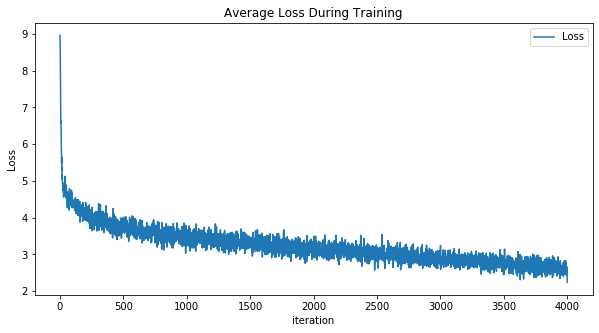

In [21]:
plt.figure(figsize=(10,5))
plt.title("Average Loss During Training")
plt.plot(lossPlot,label="Loss")
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
# evaluateInput(encoder, decoder, searcher, voc)

In [23]:
# 저장 테스트
torch.save(encoder, "./encoder")
torch.save(decoder, "./decoder")
torch.save(searcher, "./searcher")
torch.save(voc, "./voc")

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LuongAttnDecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Attn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GreedySearchDecoder. It won't be checked for correctness up

In [24]:
evaluateInput(encoder, decoder, searcher, voc)

> hello
Bot: hello . to you . it .
> q


In [25]:
'''
> hello
Bot: hello . to help . yourself .
> hello?
Bot: hello . sherman . me . .
> where am I?
Bot: you re in the records room . ?
> why?
Bot: i don t know . to marry .
> marry?
Bot: it s me . me . .
> jesus
Bot: what ? what ? ? ?
> who are you?
Bot: i m mimi . to see you .
> how are you?
Bot: fine . at the next . .
> i am sorry
Bot: i m sorry . to see you .
> good bye
Bot: good bye . . . .
> like you
Bot: like what ? me ? me ?
> love you
Bot: i love you . to marry me .
> you want to marry me?
Bot: yes . to marry you . .
> to marry you?
Bot: to the airlift . to marry me .
> airlift?
Bot: i m not sure . to marry .
> not sure?
Bot: no . to . to . .
> no?
Bot: no . to marry you . .
> you?
Bot: yes . about anything . me .
> about?
Bot: about what ? ? ? ?
> what?
Bot: i m dizzy with you . me .
> dizzy?
Bot: i m not sure . to know .
> sure?
Bot: i m sure . to see you .
> you?
Bot: yes . about anything . me .
> what?
Bot: i m dizzy with you . me .
> you eat?
Bot: i m not hungry . about it .
> why?
Bot: i don t know . to marry .
> what?
Bot: i m dizzy with you . me .
'''

'\n> hello\nBot: hello . to help . yourself .\n> hello?\nBot: hello . sherman . me . .\n> where am I?\nBot: you re in the records room . ?\n> why?\nBot: i don t know . to marry .\n> marry?\nBot: it s me . me . .\n> jesus\nBot: what ? what ? ? ?\n> who are you?\nBot: i m mimi . to see you .\n> how are you?\nBot: fine . at the next . .\n> i am sorry\nBot: i m sorry . to see you .\n> good bye\nBot: good bye . . . .\n> like you\nBot: like what ? me ? me ?\n> love you\nBot: i love you . to marry me .\n> you want to marry me?\nBot: yes . to marry you . .\n> to marry you?\nBot: to the airlift . to marry me .\n> airlift?\nBot: i m not sure . to marry .\n> not sure?\nBot: no . to . to . .\n> no?\nBot: no . to marry you . .\n> you?\nBot: yes . about anything . me .\n> about?\nBot: about what ? ? ? ?\n> what?\nBot: i m dizzy with you . me .\n> dizzy?\nBot: i m not sure . to know .\n> sure?\nBot: i m sure . to see you .\n> you?\nBot: yes . about anything . me .\n> what?\nBot: i m dizzy with you . 